In [8]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm
from tokenizers import BertWordPieceTokenizer
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader


import warnings
warnings.filterwarnings('ignore')

pip install torch pandas scikit-learn transformers tokenizers tqdm matplotlib seaborn
Run this in the terminal first


In [9]:
df_train = pd.read_json('../../Datasets/embold_train.json')
df_extended = pd.read_json('../../Datasets/embold_train_extra.json')
df_test = pd.read_json('../../Datasets/embold_test.json')

In [10]:
df_train = pd.concat([df_train, df_extended], axis=0).reset_index(drop=True)
df_train.head()
df_train.shape

(450000, 3)

Total Counts of label column: 
 label
1    207318
0    200481
2     42201
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

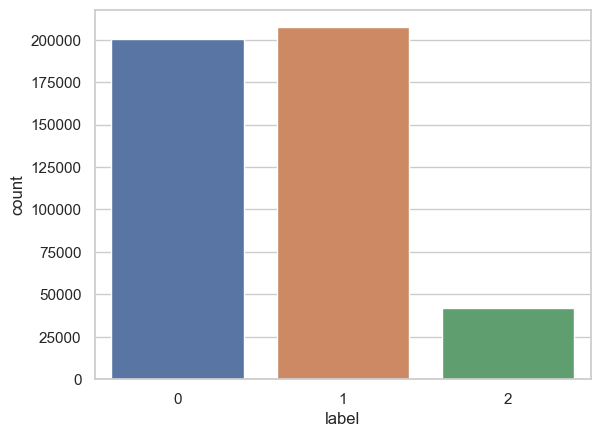

In [11]:
print('Total Counts of label column: \n'.format(),df_train['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_train)

Now we need to downsample this data to balance it


Total Counts of label column: 
 label
0    42201
1    42201
2    42201
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

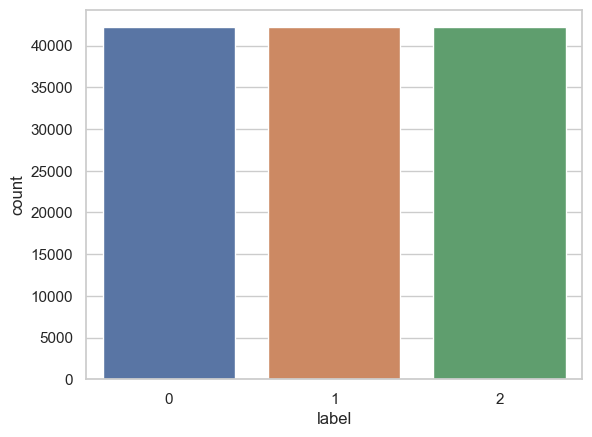

In [12]:
df_train_0 = df_train[df_train['label']==0]
df_train_1 = df_train[df_train['label']==1]
df_train_2 = df_train[df_train['label']==2]
df_train_0 = df_train_0.sample(n=df_train_2.shape[0], random_state=42)
df_train_1 = df_train_1.sample(n=df_train_2.shape[0], random_state=42)
df_train = pd.concat([df_train_0, df_train_1, df_train_2], axis=0).reset_index(drop=True)
df_train.head()
print('Total Counts of label column: \n'.format(),df_train['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_train)

In [13]:
df_train['text'] = df_train.apply(lambda x: x['title'] + ' ' + x['body'],axis=1)
df_train.head()

title  \
0                 offset div can not click in safari   
1          textfield should manage the enabled state   
2  message sanitation for ipaddresses does not ca...   
3  failed after uploading x volume s . error mess...   
4  parsing error \ log_file_id\  key in resource/...   

                                                body  label  \
0  when the div which will hold gio globe have of...      0   
1  the text field component exposes its wrapped t...      0   
2  for example:\r    \r >>> ip = ' 2a03:f80:ed15:...      0   
3  _from  soski...@gmail.com  https://code.google...      0   
4  change \ \ log_daemon_id\  to \ log_file_id\  ...      0   

                                                text  
0  offset div can not click in safari when the di...  
1  textfield should manage the enabled state the ...  
2  message sanitation for ipaddresses does not ca...  
3  failed after uploading x volume s . error mess...  
4  parsing error \ log_file_id\  key in resource/...

In [14]:
import nltk
import re
import string
from string import punctuation
from nltk.corpus import stopwords

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers'''
    text = text.replace("\\r", "")
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # text = [ch for ch in text if ch not in punctuation]
    # text = ''.join(text).split()
    # text = [word for word in text if word not in stopwords.words('english')]

    return text


def remove_stopwords(git_text):
    # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    remove_punctuation = [ch for ch in git_text if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_git_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    filtered_git_text = " ".join(filtered_git_text)
    return filtered_git_text


In [15]:
# df_train['text'] = df_train['text'].apply(lambda x: clean_text(x))
# df_train["text"] = df_train["text"].apply(remove_stopwords)
df_train = pd.read_json('../../Datasets/embold_train_cleaned.json', lines=True)
df_train.head()
# df_train.to_json('../../Datasets/embold_train_cleaned.json', orient='records', lines=True)

title  \
0                 offset div can not click in safari   
1          textfield should manage the enabled state   
2  message sanitation for ipaddresses does not ca...   
3  failed after uploading x volume s . error mess...   
4  parsing error \ log_file_id\  key in resource/...   

                                                body  label  \
0  when the div which will hold gio globe have of...      0   
1  the text field component exposes its wrapped t...      0   
2  for example:\r    \r >>> ip = ' 2a03:f80:ed15:...      0   
3  _from  soski...@gmail.com  https://code.google...      0   
4  change \ \ log_daemon_id\  to \ log_file_id\  ...      0   

                                                text  
0  offset div click safari div hold gio globe off...  
1  textfield manage enabled state text field comp...  
2  message sanitation ipaddresses call generic sa...  
3  failed uploading x volume error message except...  
4  parsing error logfileid key resourcedefaultcon...

In [17]:
class config:
    MAX_LEN = 512
    TRAIN_BATCH_SIZE = 8
    VALID_BATCH_SIZE = 4
    EPOCHS = 10
    BERT_PATH = "bert-base-uncased"
    MODEL_PATH = "model.bin"
    TRAINING_FILE = "../../Datasets/embold_train_cleaned.json"
    TOKENIZER = BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)
    truncation = True

In [18]:
# device = torch.device("cuda")
config = config()
model = BertModel.from_pretrained(config.BERT_PATH)
tokenizer = config.TOKENIZER
optimizer = AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=len(df_train) * config.EPOCHS
)
criterion = nn.CrossEntropyLoss()
# model.to(device)


In [19]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [29]:
sample_body = 'script stopped adding videos saenzramiro abc xyz'
tokens = config.TOKENIZER.tokenize(sample_body)
token_ids = config.TOKENIZER.convert_tokens_to_ids(tokens)
inputs = config.TOKENIZER([sample_body,"Hi my name is apurbo"],return_tensors='pt', padding=True, truncation=True)
print(tokens)
print(token_ids)
outputs = model(**inputs)
# pooled_outputs = outputs[1]['pooled_outputs']
print(outputs)

['script', 'stopped', 'adding', 'videos', 'sa', '##en', '##z', '##ram', '##iro', 'abc', 'x', '##y', '##z']
[5896, 3030, 5815, 6876, 7842, 2368, 2480, 6444, 9711, 5925, 1060, 2100, 2480]
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2698, -0.3179,  0.2202,  ..., -0.6247,  0.3402,  0.2039],
         [ 0.5133, -0.4863, -0.0744,  ..., -0.5429,  0.7056, -0.0575],
         [-0.1965, -0.6636, -0.1349,  ..., -0.1824,  0.2462, -0.4916],
         ...,
         [-0.1260, -0.4550,  1.4483,  ...,  0.0313,  0.0350,  0.4647],
         [ 0.1748, -0.4633,  0.7230,  ..., -0.2323,  0.1801, -0.0734],
         [ 0.4923, -0.0402, -0.1423,  ..., -0.1929, -0.4456, -0.1657]],

        [[-0.0580,  0.3298, -0.2065,  ..., -0.0295,  0.3315,  0.6102],
         [ 0.5506,  0.5631,  0.2510,  ..., -0.0713,  0.8075, -0.0295],
         [-0.2172, -0.0908, -0.4052,  ...,  0.1825, -0.0134,  0.1923],
         ...,
         [-0.2026,  0.2089,  0.3715,  ...,  0.4595,  0.2014,  0.0323],
         [-